In [17]:
library(tidyverse)
source("plotting_common.r")

In [18]:
read_problem = function(filepath) {
    dir = gsub("\\..*$", "", basename(dirname(filepath)))
    robust = grepl("robust", filepath)
    read_csv(filepath, col_types = cols()) %>% mutate(bal=dir, robust=robust)
}
read_problems = function(filepat, solvername) {
    bind_rows(lapply(Sys.glob(file.path("../ba-problems/*.problem", filepat)), read_problem)) %>%
    mutate(solver = solvername)
}

In [19]:
d0 = read_problems("multigrid_benchmark_verify.csv", "Multigrid")
d0$agg_size = 20
d0$agg = "verify"
d0$cycle = "vcycle"
d0$smooth = FALSE
d1 = read_problems("multigrid_benchmark_agg5.csv", "Multigrid")
d1$agg_size = 5
d1$agg = "vertex centric"
d1$cycle = "vcycle"
d1$smooth = FALSE
d2 = read_problems("multigrid_benchmark_default.csv", "Multigrid")
d2$agg_size = 20
d2$agg = "vertex centric"
d2$cycle = "vcycle"
d2$smooth = FALSE
d2$smoother = "pbjacobi"
d3 = read_problems("multigrid_benchmark_kcycle.csv", "Multigrid")
d3$agg_size = 20
d3$agg = "vertex centric"
d3$cycle = "kcycle"
d3$smooth = FALSE
d4 = read_problems("multigrid_benchmark_wcycle.csv", "Multigrid")
d4$agg_size = 20
d4$agg = "vertex centric"
d4$cycle = "wcycle"
d4$smooth = FALSE
d5 = read_problems("multigrid_benchmark_smooth.csv", "Multigrid")
d5$agg_size = 20
d5$agg = "vertex centric"
d5$cycle = "vcycle"
d5$smooth = TRUE
d6 = read_problems("multigrid_benchmark_bjacobi.csv", "Multigrid")
d6$agg_size = 20
d6$agg = "vertex centric"
d6$cycle = "vcycle"
d6$smooth = FALSE
d6$smoother = "bjacobi"
df = bind_rows(d0, d1, d2, d3, d4, d5, d6)
df = df %>% mutate(costmin=cummin(cost))

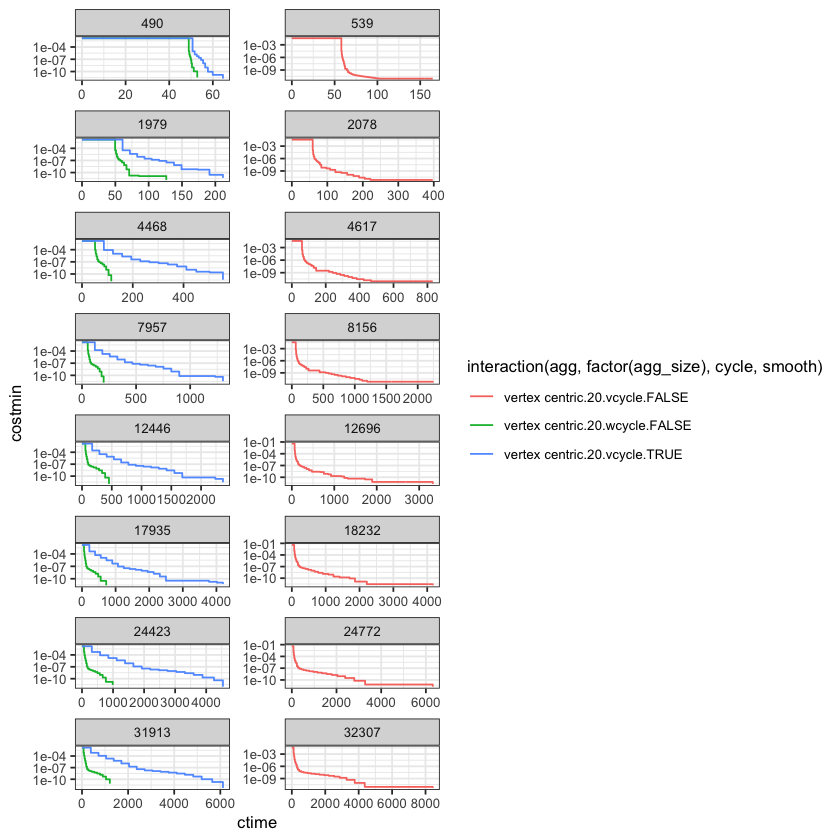

[1] "Writing to ../../thesis/cycles_comparison.tex"


pdf 
  2

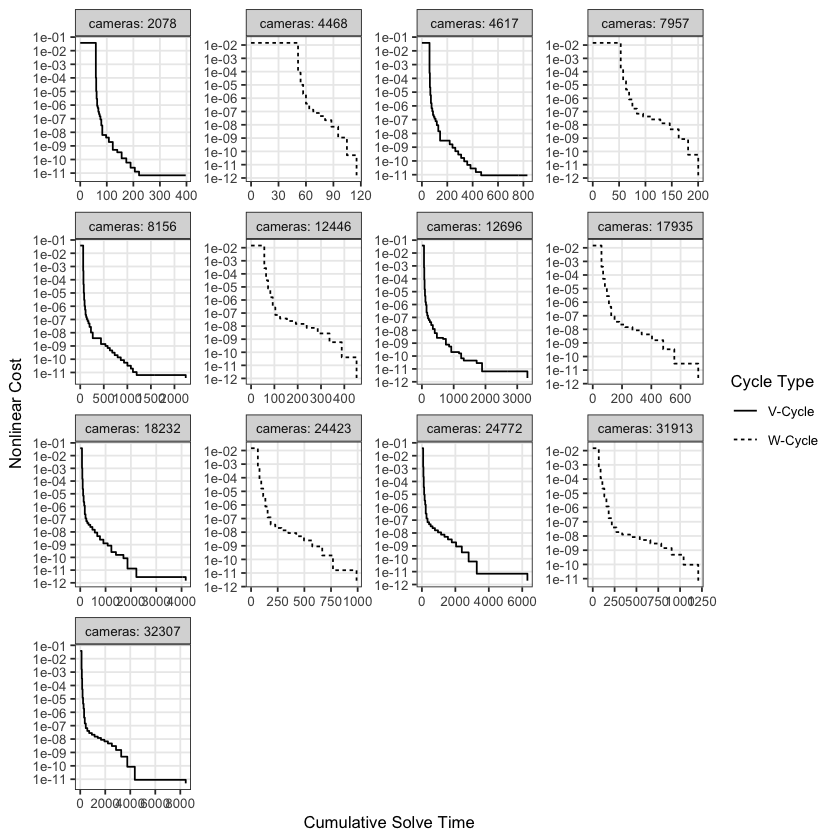

In [8]:
d = df %>% dplyr::filter(grepl("block_drift", bal)) %>%
    #dplyr::filter(cost > 1e-7) %>%
    group_by(bal, agg_size, agg, cycle, smooth, smoother) %>%
    mutate(ctime=cumsum(setup_time)+cumsum(solve_time), costmin=cummin(cost), iters=sum(iters))
ggplot(d, aes(x=ctime, y=costmin, color=interaction(agg, factor(agg_size), cycle, smooth))) +
  geom_step() +
  scale_y_log10() +
  facet_wrap(vars(cameras), ncol=2, scales="free")
ggplot(d %>% dplyr::filter(smooth==FALSE & cameras > 2000), aes(x=ctime, y=costmin, linetype=cycle)) +
  geom_step() +
  theme(panel.grid.minor = element_blank()) +
  scale_y_log_eng() +
  facet_wrap(vars(cameras), scales="free",
             labeller="label_both") +
  ylab("Nonlinear Cost") +
  xlab("Cumulative Solve Time") +
  labs(linetype="Cycle Type") +
  scale_linetype_discrete(labels=c("V-Cycle", "W-Cycle"))
tikz_file("../../thesis/cycles_comparison.tex", height=3.5)

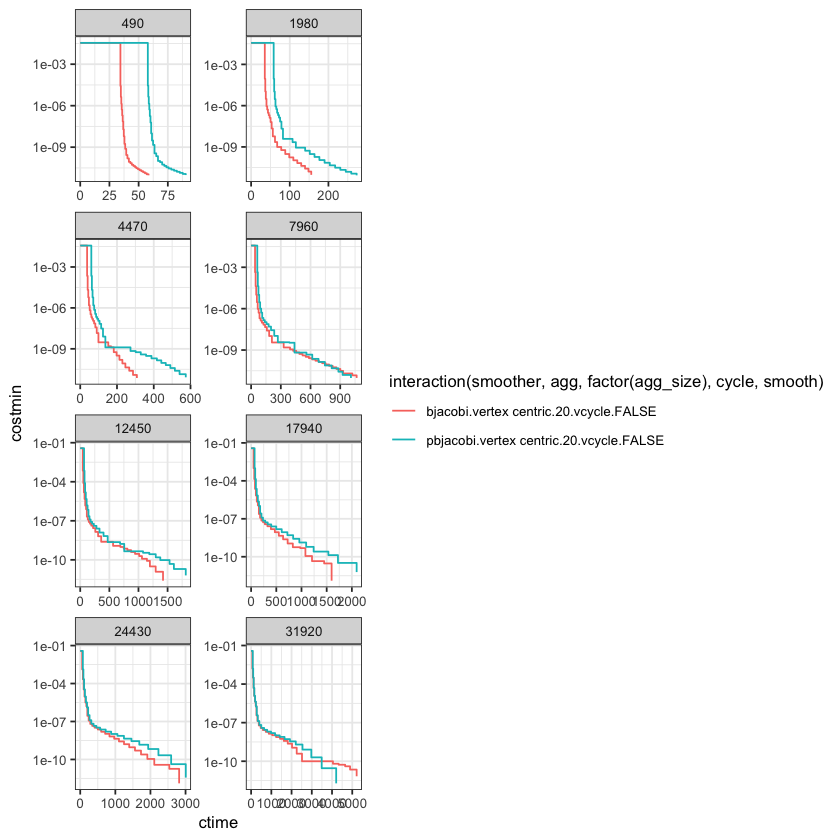

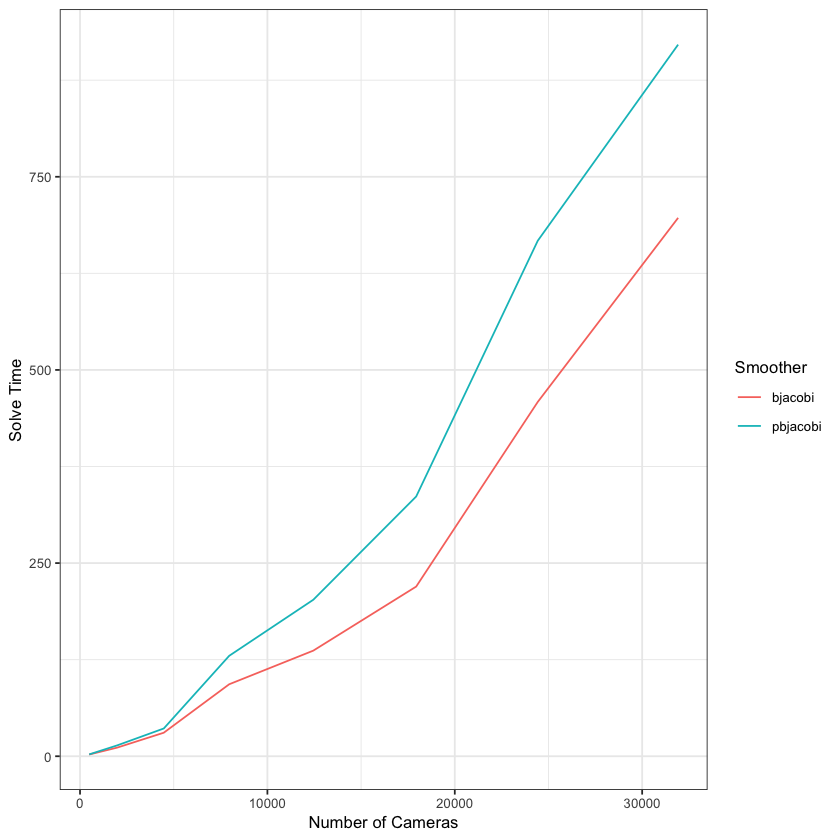

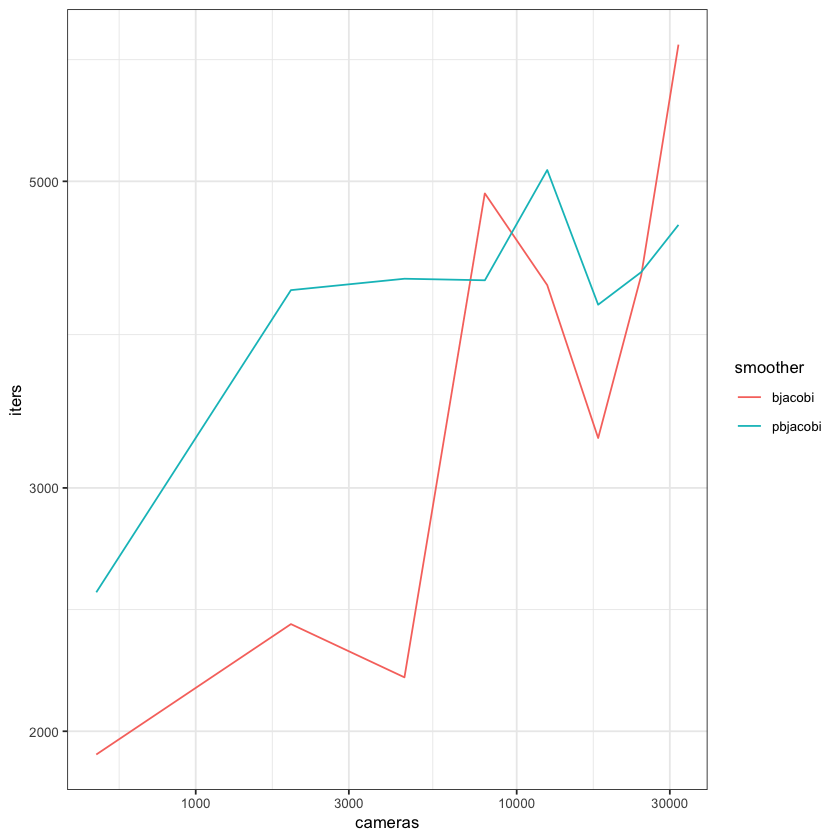

In [28]:
d = df %>% dplyr::filter(grepl("block_drift", bal)) %>%
    dplyr::filter(smoother == "pbjacobi" | smoother == "bjacobi") %>%
    group_by(bal, agg_size, agg, cycle, smooth, smoother) %>%
    mutate(ctime=cumsum(setup_time)+cumsum(solve_time), costmin=cummin(cost), iters=sum(iters))
ggplot(d, aes(x=ctime, y=costmin, color=interaction(smoother, agg, factor(agg_size), cycle, smooth))) +
  geom_step() +
  scale_y_log10() +
  facet_wrap(vars(cameras), ncol=2, scales="free")
d_agg = d %>% group_by(smoother, cameras) %>% dplyr::filter(costmin > 1e-8) %>%
              summarize(setup_time=sum(setup_time), solve_time=sum(solve_time), iters=last(iters))
ggplot(d_agg, aes(x=cameras,y=solve_time,color=smoother)) + geom_line() + ylab("Solve Time") + xlab("Number of Cameras") + labs(color="Smoother")
ggsave("../../thesis/block_smoother.pdf", width=5, height=4)
ggplot(d_agg, aes(x=cameras,y=iters,color=smoother)) + geom_line() + scale_y_log10() + scale_x_log10()

In [6]:
d = df %>% group_by(bal, agg_size, agg, cycle, solver) %>%
  summarize(total_time=sum(setup_time)+sum(solve_time)) %>% ungroup()
d %>% spread(cycle, total_time)

bal,agg_size,agg,solver,kcycle,vcycle,wcycle
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
10_block_drift,20,vertex centric,Multigrid,NA,608.59254,126.4996
15_block_drift,20,vertex centric,Multigrid,NA,1386.88851,115.3229
20_block_drift,20,vertex centric,Multigrid,NA,3542.24947,200.2140
25_block_drift,20,vertex centric,Multigrid,NA,5687.36268,452.5633
30_block_drift,20,vertex centric,Multigrid,NA,8359.14947,720.6833
35_block_drift,20,vertex centric,Multigrid,NA,10848.92356,989.7763
40_block_drift,20,vertex centric,Multigrid,NA,14548.17017,1207.8033
400_3K_10,5,vertex centric,Multigrid,NA,84.08453,NA
400_3K_10,20,verify,Multigrid,NA,83.59847,NA
